In [1]:
jointMu = 0
jointSig = 0.0000001

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import readline
import GPy
from SAM.SAM_Core import SAMCore
from SAM.SAM_Core import SAMDriver
import pylab as pb
import sys 
from sys import executable
import subprocess
from subprocess import Popen, PIPE
import pickle
import os
from os import listdir, walk, system
from os.path import isfile, join, isdir
import time
import operator
import numpy

import numpy as np
import numpy.ma as ma
np.set_printoptions(threshold=numpy.nan)
import datetime
import yarp
import copy
from itertools import combinations 
from ConfigParser import SafeConfigParser
from scipy.spatial import distance
from numpy.linalg import inv
import math
import ipyparallel as ipp
import random
from SAM.SAM_Core import staticPose

dataSetFolder = '/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset'
dataFolderList = ['lift-drop-right_arm', 
                  'lift-drop-left_arm', 
                  'push-pull-left_arm', 
                  'push-pull-right_arm']

dataFolders = []
labelFolders = []
#check folders in list actually exist
for j in dataFolderList:
    t = join(dataSetFolder,j,'data')
    m = join(dataSetFolder,j,'labels')
    if(isdir(t) and isdir(m)):
        dataFolders.append(t)
        labelFolders.append(m)
print '\n'.join(dataFolders)
print
print '\n'.join(labelFolders)
#subDirFolderList = ['camera/left', 'camera/right', 'data', 'kinect/rgb', 'labels']


/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-right_arm/data
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-left_arm/data
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-left_arm/data
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-right_arm/data

/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-right_arm/labels
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-left_arm/labels
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-left_arm/labels
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-right_arm/labels


In [3]:
def distEuc(a,b):
    temp = a-b
    temp = np.square(temp)
    temp = np.sum(temp,1)
    return np.sqrt(temp)

def qtc_2D(k,l,q,thresh):
    
    d1 = distEuc(k[:-2],l[1:-1])
    d2 = distEuc(k[1:-1],l[1:-1])
    d3 = distEuc(k[2:],l[1:-1])
    
    for i in range(len(d1)):
        #threshold distance moved
        diff1 = d2[i]-d1[i]
        if(np.abs(diff1) < thresh):
            diff1 = 0

        diff2 = d3[i]-d2[i]
        if(np.abs(diff2) < thresh):
            diff2 = 0

        #convert to qtc
        if(diff1 > 0 and diff2 > 0):
            q[i] = -1
        elif(diff1 < 0 and diff2 < 0):
            q[i] = +1
        else:
            q[i] = 0
    
    return d2

def frenetFrame(arr):
    t_num = np.diff(arr,axis=0)
    t = (t_num/np.abs(t_num)).astype(int)

    b_num = np.cross(t[:-1],t[1:])
    b = b_num/np.abs(b_num)
    t = t[1:]

    n = np.cross(b,t)

    frameArr = np.concatenate((t,n,b),axis=1).T
    fArr = frameArr.reshape((3,3,-1),order = 'F')
    return fArr

def qtc_3D(k, l, thresh, q3, q4, q5):
    fFrameK = frenetFrame(k)
    fFrameL = frenetFrame(l)
    alpArr = np.zeros(q3.shape)
    betArr = np.zeros(q3.shape)
    gamArr = np.zeros(q3.shape)
    
    for g in range(fFrameK.shape[2]):
        fKinv = np.linalg.pinv(fFrameK[:,:,g])
        R = np.dot(fFrameL[:,:,g],fKinv)
        
        alpha = np.arctan(R[1,0]/R[0,0])
        den = np.sqrt(pow(R[2,1],2) + pow(R[2,2],2))
        
        beta = np.arctan(-R[2,0]/den)
        gamma = np.arctan(R[2,1]/R[2,2])

        #threshold angles
        if(np.abs(alpha) < thresh or math.isnan(alpha)):
            alpha = 0
        if(np.abs(beta) < thresh or math.isnan(beta)):
            beta = 0
        if(np.abs(gamma) < thresh or math.isnan(gamma)):
            gamma = 0
        alpArr[g] = alpha
        betArr[g] = beta
        gamArr[g] = gamma
        
        q3[g] = np.sign(alpha)
        q4[g] = np.sign(beta)
        q5[g] = np.sign(gamma)
    
    return [alpArr,betArr,gamArr]
            
def checkQTC(qtcArr):
    #array of shape x by 11 with 0 to 4 of 11 being the ones that unique must apply to
    tArr = copy.deepcopy(qtcArr)
    for i in range(1,tArr.shape[0]):
        if(i != 0):
            currRow = tArr[i,:]
            Mod = False
            for q in range(tArr.shape[1]):
                r = tArr[i,q] - tArr[i-1,q]
                if(r == -2 or r == 2):
                    Mod = True
                    currRow[q] = 0
            if(Mod):    
                qtcArr = np.insert(qtcArr,i,currRow,axis=0)    
                Mod = False
    return qtcArr

def uniqueQTC(currQTC):
    #array of shape x by 11 with 0 to 4 of 11 being the ones that unique must apply to
    i = 0
    del1 = False
    del2 = False
    
    while(i < currQTC.shape[0]-2):
        if(i!=0):
            if(np.array_equal(currQTC[i,:5],currQTC[i-1,:5])):
                del1 = True
            if(np.array_equal(currQTC[i+1,:5],currQTC[i-1,:5])):
                del2 = True
        
        if(del1 and not del2):
            currQTC = np.delete(currQTC,i,0)
        elif(del2):
            currQTC = np.delete(currQTC,i,0)
            currQTC = np.delete(currQTC,i+1,0)
            
        i+=1
    return currQTC

In [4]:
#load kinect skeleton data for all folders in dataFolderList
numJoints = 9
data = dict()
firstPass = True
jointsList = []
objectsList = []
labelsList = []
numFolders = len(dataFolders)

for j in dataFolders:
    k = dataFolders.index(j)
    dataFile = open(join(dataFolders[k],'data.log'),'r')
    labelFile = open(join(labelFolders[k],'data.log'),'r')
    
    #number of lines in dataFile
    for i, l in enumerate(dataFile):
            pass
    lenDataFile = i+1
    
    #number of lines in labelFile
    for i, l in enumerate(labelFile):
            pass
    lenLabelFile = i+1
    dataFile.close()
    labelFile.close()
    
    
    if(lenLabelFile != lenDataFile):
        raise ValueError('Files not of same lenght')
    else:
        dataFile = open(join(dataFolders[k],'data.log'),'r')
        labelFile = open(join(labelFolders[k],'data.log'),'r')
        labelsList.append([])
        
        for curr in range(lenDataFile):
            line = dataFile.readline()
            labelLine = labelFile.readline()
            
            t = line.replace('(','').replace(')','').split(' ')
            del t[0:4]
           
            v = labelLine.split(' ')[2].replace('\n','').replace('(','').replace(')','')
            if(v == ''):
                v = 'unknown'
            labelsList[k].append(v)
            
            #parse skeleton data which has 9 sections by (x,y,z)
            for i in range(numJoints):
                a = i*4
                if(t[a] == 'shoulderCenter'):
                    t[a] = 'chest'
                
                if(firstPass):
                    data[t[a]] = [None]*numFolders
                    data[t[a]][k] = (np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])]))
                    jointsList.append(t[a])
                else:
                    arr =  np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])])
                    if(data[t[a]][k] != None):
                        data[t[a]][k] = np.vstack((data[t[a]][k],arr))
                    else:
                        data[t[a]][k] = arr

            currIdx = (numJoints*4 -1)
            numObjs = (len(t) - currIdx)/5

            for i in range(numObjs):
                a = currIdx + 1 + (i*5)
                if(t[a] in data):
                    arr = np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])])
                    if(data[t[a]][k] != None):
                        data[t[a]][k] =  np.vstack((data[t[a]][k],arr))
                    else:
                        data[t[a]][k] = arr
                else:
                    data[t[a]] = [None]*(numFolders)
                    data[t[a]][k] = np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])])
                    objectsList.append(t[a])

            firstPass = False
            
        dataFile.close()
        labelFile.close()

 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:59: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:71: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


In [5]:
print 'data has length = ' + str(len(data)) + ' joints'
strl =  'each joint has ' + str(len(data['head'])) + ' arrays of shape: '

for i in data['head']:
    strl += str(i.shape) + ', '
print strl

strl = 'labelsList has length = ' + str(len(labelsList)) + ' with sizes: '
for i in labelsList:
    strl += str(len(i)) + ', '
print strl

data has length = 12 joints
each joint has 4 arrays of shape: (4637, 3), (4907, 3), (5914, 3), (5440, 3), 
labelsList has length = 4 with sizes: 4637, 4907, 5914, 5440, 


In [6]:
#compile a list of all unique labels
setList = []
for x in labelsList:
    setList.append(list(set(x)))
flattenedList = [val for sublist in setList for val in sublist]
labels = list(set(flattenedList))
labels.sort()
for k in range(0,len(labels)):
    print str(k) + '  ' + labels[k]
    


0  agent_entry
1  agent_exit
2  arms_lowered
3  arms_raised
4  carry_object_car_hand_left
5  carry_object_car_hand_left_no
6  carry_object_car_hand_right
7  carry_object_car_hand_right_no
8  drop_object_car_hand_left
9  drop_object_car_hand_left_no
10  drop_object_car_hand_right
11  drop_object_car_hand_right_no
12  dropping_arms
13  lift_object_car_hand_left
14  lift_object_car_hand_left_no
15  lift_object_car_hand_right_no
16  no_agent
17  pull_object_car_hand_left
18  pull_object_car_hand_left_no
19  pull_object_car_hand_right
20  pull_object_car_hand_right_no
21  pull_object_octopus_hand_left
22  pull_object_octopus_hand_left_no
23  pull_object_octopus_hand_right
24  push_object_car_hand_left
25  push_object_car_hand_left_no
26  push_object_car_hand_right
27  push_object_car_hand_right_no
28  push_object_octopus_hand_left
29  push_object_octopus_hand_left_no
30  push_object_octopus_hand_right
31  push_object_octopus_hand_right_no
32  raising_arms
33  reach_object_car_hand_left
34  

In [7]:
print range(len(dataFolderList))
print len(dataFolderList)
print dataFolderList[3:4]

[0, 1, 2, 3]
4
['push-pull-right_arm']


In [8]:
dataStruct = []
verbose = True
for arr in range(len(dataFolderList)):
    for label in labels:
        if(verbose):
            print
            print 'current dataset = ' + str(dataFolderList[arr])
            print 'curent label: ' + str(label)
            print
        idxs = [i for i in range(len(labelsList[arr])) if labelsList[arr][i] == label]
        actionBlocks = []
        startIdx = 0
        if(len(idxs) > 5):
            for idxIndex in range(len(idxs)):
                if(idxIndex != 0):
                    if(idxs[idxIndex] - idxs[idxIndex-1] != 1):
                        if(idxIndex-startIdx > 5):
                            for joint in jointsList+objectsList[1:]:
                                actionData = data[joint][arr][idxs[startIdx:idxIndex]]
                                dataStruct.append([joint, label, arr, actionData.shape[0], actionData])
                                if(verbose):
                                    print '[%s]' % ', '.join(map(str, dataStruct[-1][:-1]))
                            startIdx = idxIndex

                    if(idxIndex+2 > len(idxs)):
                        if(idxs[idxIndex] - idxs[idxIndex-1] != 1):
                            for joint in jointsList+objectsList[1:]:
                                actionData = data[joint][arr][idxs[startIdx:idxIndex+1]]
                                dataStruct.append([joint, label, arr, actionData.shape[0], actionData])
                                if(verbose):
                                    print '[%s]' % ', '.join(map(str, dataStruct[-1][:-1]))
            print '------------------------------------------------------------------------'



current dataset = lift-drop-right_arm
curent label: agent_entry

------------------------------------------------------------------------

current dataset = lift-drop-right_arm
curent label: agent_exit

------------------------------------------------------------------------

current dataset = lift-drop-right_arm
curent label: arms_lowered

[elbowLeft, arms_lowered, 0, 31]
[elbowRight, arms_lowered, 0, 31]
[handLeft, arms_lowered, 0, 31]
[handRight, arms_lowered, 0, 31]
[head, arms_lowered, 0, 31]
[chest, arms_lowered, 0, 31]
[shoulderLeft, arms_lowered, 0, 31]
[shoulderRight, arms_lowered, 0, 31]
[spine, arms_lowered, 0, 31]
[car, arms_lowered, 0, 31]
[octopus, arms_lowered, 0, 31]
[elbowLeft, arms_lowered, 0, 17]
[elbowRight, arms_lowered, 0, 17]
[handLeft, arms_lowered, 0, 17]
[handRight, arms_lowered, 0, 17]
[head, arms_lowered, 0, 17]
[chest, arms_lowered, 0, 17]
[shoulderLeft, arms_lowered, 0, 17]
[shoulderRight, arms_lowered, 0, 17]
[spine, arms_lowered, 0, 17]
[car, arms_lower

In [9]:
joint = 0
action = 1
dataset = 2
start = 3
end = 4
for a in range(len(dataFolderList)):
    print 'Dataset ' + str(a) + ' : ' + dataFolderList[a]
    for b in range(len(labels)):
        if('no' not in labels[b]):
            y = len([i[1] for i in dataStruct if i[joint] == 'head' and i[dataset] == a and i[action] == labels[b]])
            print '\t ' + str(labels[b]).ljust(35) + ' = ' + str(y).ljust(3) + ' repetitions'
    print



Dataset 0 : lift-drop-right_arm
	 agent_entry                         = 0   repetitions
	 agent_exit                          = 0   repetitions
	 arms_lowered                        = 23  repetitions
	 arms_raised                         = 1   repetitions
	 carry_object_car_hand_left          = 0   repetitions
	 carry_object_car_hand_right         = 0   repetitions
	 drop_object_car_hand_left           = 0   repetitions
	 drop_object_car_hand_right          = 0   repetitions
	 dropping_arms                       = 3   repetitions
	 lift_object_car_hand_left           = 0   repetitions
	 pull_object_car_hand_left           = 0   repetitions
	 pull_object_car_hand_right          = 0   repetitions
	 pull_object_octopus_hand_left       = 0   repetitions
	 pull_object_octopus_hand_right      = 0   repetitions
	 push_object_car_hand_left           = 0   repetitions
	 push_object_car_hand_right          = 0   repetitions
	 push_object_octopus_hand_left       = 0   repetitions
	 push_object_oc

In [10]:
joint = 0
action = 1
dataset = 2
start = 3
end = 4

for b in range(len(labels)):
    if('no' not in labels[b]):
        y = 0
        for a in range(len(dataFolderList)):
            y += len([i[1] for i in dataStruct if i[joint] == 'head' and i[dataset] == a and i[action] == labels[b]])
        print '\t ' + str(labels[b]).ljust(35) + ' = ' + str(y).ljust(3) + ' repetitions'

	 agent_entry                         = 0   repetitions
	 agent_exit                          = 0   repetitions
	 arms_lowered                        = 47  repetitions
	 arms_raised                         = 67  repetitions
	 carry_object_car_hand_left          = 10  repetitions
	 carry_object_car_hand_right         = 0   repetitions
	 drop_object_car_hand_left           = 11  repetitions
	 drop_object_car_hand_right          = 0   repetitions
	 dropping_arms                       = 10  repetitions
	 lift_object_car_hand_left           = 11  repetitions
	 pull_object_car_hand_left           = 7   repetitions
	 pull_object_car_hand_right          = 11  repetitions
	 pull_object_octopus_hand_left       = 9   repetitions
	 pull_object_octopus_hand_right      = 10  repetitions
	 push_object_car_hand_left           = 12  repetitions
	 push_object_car_hand_right          = 11  repetitions
	 push_object_octopus_hand_left       = 7   repetitions
	 push_object_octopus_hand_right      = 14  repe

In [11]:
#Calibrate contact threshold
# data has length = 12 joints
# each joint has 4 arrays of shape: (4637, 3), (4907, 3), (5914, 3), (5440, 3), 
# labelsList has length = 4 with sizes: 4637, 4907, 5914, 5440, 
handPos = np.zeros((1,3))
objectPos = np.zeros((1,3))

# push_object_car_hand_right

for i in range(len(labelsList)):
    for j in range(len(labelsList[i])):
        if('object' in labelsList[i][j] and 'reach' not in labelsList[i][j] and "no" not in labelsList[i][j]):
            if('left' in labelsList[i][j]):
                handPos = np.vstack((handPos,data['handLeft'][i][j,:,None].T))
                obj = labelsList[i][j].split('_')[2]
                objectPos = np.vstack((objectPos,data[obj][i][j,:,None].T))
                
            if('right' in labelsList[i][j]):
                handPos = np.vstack((handPos,data['handRight'][i][j,:, None].T))
                obj = labelsList[i][j].split('_')[2]
                objectPos = np.vstack((objectPos,data[obj][i][j,:,None].T))

d = distEuc(handPos, objectPos)
perc = 98
print 'Mean of contact distances = ' + str(np.mean(d))
print 'Median of contact distances = '  + str(np.median(d))
print 'Max contact distance = ' + str(np.max(d))
print 'Min contact distance = ' + str(np.min(d))
print str(perc)+'% percentile contact distance = ' + str(np.percentile(d,perc))

Mean of contact distances = 0.11143710217
Median of contact distances = 0.107711559875
Max contact distance = 0.343510114671
Min contact distance = 0.0
98% percentile contact distance = 0.213788154879


In [12]:
jointsList.sort()
modJointsListHand_R = [i for i in jointsList if i != 'elbowRight' and i != 'handRight']
modJointsListHand_L = [i for i in jointsList if i != 'elbowLeft' and i != 'handLeft']

modJointsListHand_R = []
modJointsListHand_L = []
combinationList = []

if(len(modJointsListHand_R) > 0):
    for i in range(len(modJointsListHand_R)):
        combinationList.append(['handLeft', modJointsListHand_L[i]])
        combinationList.append(['handRight', modJointsListHand_R[i]])
    del combinationList[combinationList.index(['handLeft', 'handRight'])]

for i in objectsList[1:]:
    combinationList.append(['handLeft',i])
    combinationList.append(['handRight',i])


print 'Available joint pairs for hands:'
print
for i in combinationList:
    print '\t' + str(i)

Available joint pairs for hands:

	['handLeft', 'car']
	['handRight', 'car']
	['handLeft', 'octopus']
	['handRight', 'octopus']


In [13]:
humanStaticLabels = []
humanStaticLabels.append('left of')
humanStaticLabels.append('right of')
humanStaticLabels.append('on top of')
humanStaticLabels.append('underneath')
humanStaticLabels.append('in front of')
humanStaticLabels.append('behind')
humanStaticLabels.append('stationary')

In [14]:
joint = 0
action = 1
dataset = 2
start = 3
end = 4

actionsAllowedList = ['lift_object', 'pull_object', 'push_object', 'drop_object', 'carry_object']
#actionsAllowedList = ['lift_object', 'drop_object']
actionsAllowed = []

for ac in actionsAllowedList:
    temp = [g for g in labels if ac in g and "no" not in g]
    for h in range(len(temp)):
        actionsAllowed.append(temp[h])

for b in range(len(labels)):
#     print labels[b]
    if('no' not in labels[b] and labels[b] in actionsAllowed):
        y = 0
        for a in range(len(dataFolderList)):
            y += len([i[1] for i in dataStruct if i[joint] == 'head' and i[dataset] == a and i[action] == labels[b]])
        print '\t ' + str(labels[b]).ljust(35) + ' = ' + str(y).ljust(3) + ' repetitions'

	 carry_object_car_hand_left          = 10  repetitions
	 carry_object_car_hand_right         = 0   repetitions
	 drop_object_car_hand_left           = 11  repetitions
	 drop_object_car_hand_right          = 0   repetitions
	 lift_object_car_hand_left           = 11  repetitions
	 pull_object_car_hand_left           = 7   repetitions
	 pull_object_car_hand_right          = 11  repetitions
	 pull_object_octopus_hand_left       = 9   repetitions
	 pull_object_octopus_hand_right      = 10  repetitions
	 push_object_car_hand_left           = 12  repetitions
	 push_object_car_hand_right          = 11  repetitions
	 push_object_octopus_hand_left       = 7   repetitions
	 push_object_octopus_hand_right      = 14  repetitions


In [15]:
def labelize(qin, qout):
    for h in range(qin.shape[0]):
        #x at 0 is depth with negative meaning behind an object
        #y at 1 is width with negative meaning partner-right = ego-left
        #x at 2 is height with negative meaning underneath
        currVec = np.abs(qin[h,:])
        if(currVec.sum() != 0):
            maxIDx = currVec.argmax()
            if(maxIDx == 0):
                if(np.sign(qin[h,maxIDx]) == -1):
                    #behind
                    qout[h] = humanStaticLabels.index('behind')
                elif(np.sign(qin[h,maxIDx]) == 1):
                    #in front
                    qout[h] = humanStaticLabels.index('in front of')
            elif(maxIDx == 1):
                if(np.sign(qin[h,maxIDx]) == -1):
                    #left
                    qout[h] = humanStaticLabels.index('left of')
                elif(np.sign(qin[h,maxIDx]) == 1):
                    #right
                    qout[h] = humanStaticLabels.index('right of')
            elif(maxIDx == 2):
                if(np.sign(qin[h,maxIDx]) == -1):
                    #underneath
                    qout[h] = humanStaticLabels.index('underneath')
                elif(np.sign(qin[h,maxIDx]) == 1):
                    #top of
                    qout[h] = humanStaticLabels.index('on top of')  
        else:
            qout[h] = humanStaticLabels.index('stationary')
    

In [16]:
def filterMovement(ts, thresh):
    lastMove = 0
    stillThere = True
    
    for timestep in range(1, ts.shape[0]):
        g = np.sqrt(np.sum(np.square(ts[timestep,:]-ts[lastMove,:])))
        if(g >= thresh):
            lastMove = timestep
            stillThere = False
#             print str(g).ljust(20) + ' shift'
        else:
#             print str(g).ljust(20) + ' still there'
            ts[timestep] = ts[lastMove]
#             if(stillThere):
#                 print 'delete'
#                 #np.delete(ts, timestep, axis = 0)
#             else:
#                 print 'no delete'
#                 stillThere = True

def removeStationary(inputArr, labelRemove, indsToCheck):
    i = 0
    while(i < inputArr.shape[0]):
        logic = True 
        for j in indsToCheck: 
            if(inputArr[i][j] == labelRemove):
                logic = logic and True
            else:
                logic = logic and False
        
        if(logic): #if labelRemove was present in all indsToCheck remove row
            inputArr = np.delete(inputArr,i,0)
        else:
            i += 1
    return inputArr

def formatFeatures(inputArr, idx):
    vec = np.zeros((len(humanStaticLabels)+1))
    for i in range(len(inputArr)):
        vec[inputArr[i][idx]] += 1
    vec[-1] = len(inputArr)
    return vec
        

In [17]:
#2 joint pairs will be used shoulder-hand and hand-object left and right doesnt matter
#both combine within a single model
#step 1 will be training these models with static poses to do clustering with a full GP configuration
joint = 0
action = 1
dataset = 2
start = 3
end = 4
verbose = True

contactThreshold = 0.2 #between 0.1 and 0.2 value smaller than which contact occurs
deltaDistanceThreshold = 0.01 #distance to move between frames for point-point relative movement to be considered true1
angleThreshold = 0.001
labelToRemove = humanStaticLabels.index('stationary');
indsToRemove = [18]

firstPass = True
handDataStruct = []

for currComb in combinationList:
    print str(currComb[0]) +'-' +str(currComb[1])
    infoK = [i for i in dataStruct if i[joint] == currComb[0]]
    infoL = [i for i in dataStruct if i[joint] == currComb[1]]
    for i in range(len(infoK)):
        if(infoK[i][1] in actionsAllowed):
            if('hand' in infoK[i][0] and 'object' in infoK[i][1]):
                if('Left' in infoK[i][0] and 'left' in infoK[i][1]):
                    condition = True
                elif('Right' in infoK[i][0] and 'right' in infoK[i][1]):
                    condition = True
                else:
                    condition = False
                    
                if(infoL[i][0] not in infoK[i][1]):
                    condition = False
                    obj = True
                    
            elif('hand' not in infoK[i][0] and 'object' in infoK[i][1]):
                condition = False
            else:
                condition = True
        else:
            condition = False
             
            
#         condition = False
        if(condition):
            
            Pk = infoK[i][4]
            Pl = infoL[i][4]

            #add gaussian noise on output
            Pk_Noise = np.random.normal(jointMu, jointSig, Pk.shape)
            Pl_Noise = np.random.normal(jointMu, jointSig, Pl.shape)

            Pk = Pk + Pk_Noise
            Pl = Pl + Pl_Noise

            q1 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #motion of k relative to l
            q2 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #motion of l relative to k
            q3 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #alpha
            q4 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #beta
            q5 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #gamma
            q7 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #contact
            q8 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #human static label
            
            filterMovement(Pk, deltaDistanceThreshold)
            filterMovement(Pl, deltaDistanceThreshold)
            

            q6 = (Pl[1:-1]-Pk[1:-1]) #direction vector from joint to joint

            q9 = qtc_2D(Pk,Pl,q1, deltaDistanceThreshold)
            lowV = np.abs(q9) < contactThreshold
            q7[lowV] = 1

            q6 = q6/q9[:,None]

            qtc_2D(Pl,Pk,q2, deltaDistanceThreshold)
            [a,b,g] = qtc_3D(Pk, Pl, angleThreshold, q3, q4, q5)
            
            labelize(q6,q8)

            q10 = Pl[1:-1]
            q11 = Pk[1:-1]
            
            q13 = np.ones((Pk.shape[0]-2,1), dtype=np.int)
            q12mag = distEuc(Pk[1:-1],Pk[:-2])
            lowV = np.abs(q12mag) < deltaDistanceThreshold
            q12 = (Pk[1:-1] - Pk[:-2])/q12mag[:,None]
            q12[lowV] = 0
            labelize(q12,q13)

            q15 = np.ones((Pk.shape[0]-2,1), dtype=np.int)
            q14mag = distEuc(Pl[1:-1],Pl[:-2])
            lowV = np.abs(q14mag) < deltaDistanceThreshold
            q14 = (Pl[1:-1] - Pl[:-2])/q14mag[:,None]
            q14[lowV] = 0
            labelize(q14,q15)
                
            tempQTC = np.hstack((q1,q2,q3,q4,q5,q6[:,0,None],q6[:,1,None],q6[:,2,None],q7,q8,q9[:,None],q10[:,0,None],q10[:,1,None],q10[:,2,None],q11[:,0,None],q11[:,1,None],q11[:,2,None],q13,q15))
    #         g = tempQTC.shape[0]
    #         tempQTC2 = uniqueQTC(tempQTC)

    #         gg = tempQTC2.shape[0]

    #         tempQTC = checkQTC(tempQTC2)

    #         ggg = tempQTC.shape[0]
            
            tempQTC = removeStationary(tempQTC, labelToRemove, indsToRemove)
#             v = formatFeatures(tempQTC, 18)
            handDataStruct.append([currComb[0], currComb[1], infoK[i][1], infoK[i][2], tempQTC.shape[0], tempQTC])

            if(verbose):
                print '[%s]' % ', '.join(map(str, handDataStruct[-1][:-1]))
                #print v
    #             print str((ggg-gg)).ljust(3) + ' added in check QTC'
    #             print str((gg-g)).ljust(3) + ' added in unique QT


handLeft-car
[handLeft, car, carry_object_car_hand_left, 1, 0]
[handLeft, car, carry_object_car_hand_left, 1, 3]
[handLeft, car, carry_object_car_hand_left, 1, 7]
[handLeft, car, carry_object_car_hand_left, 1, 15]
[handLeft, car, carry_object_car_hand_left, 1, 4]
[handLeft, car, carry_object_car_hand_left, 1, 9]
[handLeft, car, carry_object_car_hand_left, 1, 8]
[handLeft, car, carry_object_car_hand_left, 1, 11]
[handLeft, car, carry_object_car_hand_left, 1, 8]
[handLeft, car, carry_object_car_hand_left, 1, 5]
[handLeft, car, drop_object_car_hand_left, 1, 5]
[handLeft, car, drop_object_car_hand_left, 1, 6]
[handLeft, car, drop_object_car_hand_left, 1, 7]
[handLeft, car, drop_object_car_hand_left, 1, 4]
[handLeft, car, drop_object_car_hand_left, 1, 8]
[handLeft, car, drop_object_car_hand_left, 1, 5]
[handLeft, car, drop_object_car_hand_left, 1, 2]
[handLeft, car, drop_object_car_hand_left, 1, 12]
[handLeft, car, drop_object_car_hand_left, 1, 7]
[handLeft, car, drop_object_car_hand_left, 

 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning:invalid value encountered in divide
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning:divide by zero encountered in divide
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:90: RuntimeWarning:invalid value encountered in divide
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:97: RuntimeWarning:invalid value encountered in divide


[handLeft, car, pull_object_car_hand_left, 2, 6]
[handLeft, car, pull_object_car_hand_left, 2, 8]
[handLeft, car, pull_object_car_hand_left, 2, 7]
[handLeft, car, pull_object_car_hand_left, 2, 12]
[handLeft, car, pull_object_car_hand_left, 2, 11]
[handLeft, car, push_object_car_hand_left, 2, 5]
[handLeft, car, push_object_car_hand_left, 2, 4]
[handLeft, car, push_object_car_hand_left, 2, 9]
[handLeft, car, push_object_car_hand_left, 2, 19]
[handLeft, car, push_object_car_hand_left, 2, 9]
[handLeft, car, push_object_car_hand_left, 2, 12]
[handLeft, car, push_object_car_hand_left, 2, 8]
[handLeft, car, push_object_car_hand_left, 2, 10]
[handLeft, car, push_object_car_hand_left, 2, 7]
[handLeft, car, push_object_car_hand_left, 2, 16]
[handLeft, car, push_object_car_hand_left, 2, 6]
[handLeft, car, push_object_car_hand_left, 2, 12]
handRight-car
[handRight, car, pull_object_car_hand_right, 3, 7]
[handRight, car, pull_object_car_hand_right, 3, 2]
[handRight, car, pull_object_car_hand_right,

In [18]:
#q1,q2         [0:2]   -> relative movement of points in terms of distance from each other (closer / farther)
#q3-5          [2:5]   -> relative movement of joints in tems of orientation from each other (difference in the paths they are following wrt each other)
#q6_1 to _3    [5:8]   -> direction vector from hand to other joint
#q7            [8]     -> contact status
#q8            [9]     -> instantaneous relative position of K wrt L
#q9            [10]    -> distance of points
#q10_1 to _3   [11:14] -> position of l
#q11_1 to _3   [14:17] -> position of k

featureSections = dict()
featureValues = dict()
featureSections['QTC_Motion'] = range(0,2)
featureValues['QTC_Motion'] = [-1,0,1]

featureSections['QTC_Orientation'] = range(2,5)
featureValues['QTC_Orientation'] = [-1,0,1]

featureSections['directionVector'] = range(5,8)
featureValues['directionVector'] = []

featureSections['contact'] = [8]
featureValues['contact'] = [0,1]

featureSections['relativePositionLabel'] = [9]
featureValues['relativePositionLabel'] = range(len(humanStaticLabels))

featureSections['euc_distance'] = [10]
featureValues['euc_distance'] = []

featureSections['posL'] = range(11,14)
featureValues['posL'] = []

featureSections['posK'] = range(14,17)
featureValues['posK'] = []

featureSections['selfMovementLabelL'] = [17]
featureValues['selfMovementLabelL']   = range(len(humanStaticLabels))

featureSections['selfMovementLabelK'] = [18]
featureValues['selfMovementLabelK']   = range(len(humanStaticLabels))


featureToUse = ['contact', 'selfMovementLabelK']
#selfMovementLabelK movement of hand
#selfMovementLabelL movement of object
featureInds = []
for h in featureToUse:
    featureInds += featureSections[h]
    
    
print featureInds

[8, 18]


In [19]:
for i in range(len(humanStaticLabels)):
    print str(i).ljust(2) + ': ' + str(humanStaticLabels[i])
#     

0 : left of
1 : right of
2 : on top of
3 : underneath
4 : in front of
5 : behind
6 : stationary


In [20]:
def formatFeatures2(inputArr, idx, valsPossible):
#     print str(valsPossible) + str(len(valsPossible))
#     print str(idx) +str(len(idx))
    if(valsPossible != None):
        vec = np.zeros((len(valsPossible)*len(idx)))
        for b in range(len(idx)):
            for i in range(len(inputArr)):
                
                offset = (len(valsPossible)*b)
                vec[offset + valsPossible.index(inputArr[i][idx[b]])] += 1
#                 print
#         print vec
        return vec
    else:
        return np.array(-1)
    

for n in range(len(handDataStruct)):
#     print handDataStruct[n][0:3]
#     print featureToUse
#     print handDataStruct[n][5][:,featureInds]
    v = np.array(len(handDataStruct[n][5]))
    for j in featureToUse:
        vec = formatFeatures2(handDataStruct[n][5], featureSections[j], featureValues[j])
        if(vec[0] !=  -1):
            v = np.hstack((v,vec))
    handDataStruct[n][5] = v

In [21]:
#here model trains recognition of object location wrt each other
#feature vector => handDataStruct[5][:,5:8](vector from hand to object) and humanlabel handDataStruct[5][:,9]
#actionsAllowedList = ['lift_object', 'pull_object', 'push_object', 'drop_object',]

for a in range(len(handDataStruct)):
    for r in actionsAllowedList:
        if r in handDataStruct[a][2]:
            labelNum = actionsAllowedList.index(r)

    if(a == 0):
        allPoseY = handDataStruct[a][5]
        allPoseL = labelNum
    else:
        allPoseY = np.vstack((allPoseY, handDataStruct[a][5]))
        allPoseL = np.vstack((allPoseL, labelNum))
        
print allPoseY.shape
print allPoseL.shape


(113, 10)
(113, 1)


In [22]:
k = 0
ratio = 70
numItems = 300

for k in range(len(actionsAllowedList)):
    this_label = [i for i in range(allPoseL.shape[0]) if allPoseL[i] == k]
    this_Y = allPoseY[this_label]
    this_L = allPoseL[this_label]
    if(len(this_L)< numItems-1):
        Idx = range(len(this_L))
    else:
        Idx = [ i for i in sorted(random.sample(xrange(len(this_L)),numItems)) ]
        
    if(k == 0):
        staticPoseY = np.asarray([this_Y[i] for i in Idx])
        staticPoseL = np.asarray([this_L[i] for i in Idx])
    else:
        print staticPoseY.shape
        print np.asarray([this_Y[i] for i in Idx]).shape
        staticPoseY = np.vstack((staticPoseY, np.asarray([this_Y[i] for i in Idx])))
        staticPoseL = np.vstack((staticPoseL, np.asarray([this_L[i] for i in Idx])))
        print
        
print len(this_label)
print len(this_Y)
j = np.asarray(this_label)
print j.shape
print this_Y.shape
print this_L.shape
print staticPoseY.shape
print staticPoseL.shape

(11, 10)
(37, 10)

(48, 10)
(44, 10)

(92, 10)
(11, 10)

(103, 10)
(10, 10)

10
10
(10,)
(10, 10)
(10, 1)
(113, 10)
(113, 1)


In [23]:
staticPoseModel = staticPose.staticPose()
staticPoseModel.readData(0,0,staticPoseY,staticPoseL, actionsAllowedList)

staticPoseModel.Quser = 2
Ntr = int(len(staticPoseModel.L)*ratio/100)
model_type = 'mrd'
model_num_inducing = 10
model_num_iterations = 800 #100
model_init_iterations = 800 #300
save_model=True
economy_save = True
visualise_output=True
experiment_number = 3
fname = '/home/daniel/SAM_Data_Models/Models/objectActions_exp' + str(experiment_number)

[Yall,Lall,YtestAll,LtestAll] = staticPoseModel.prepareData (model_type, Ntr,randSeed=experiment_number)


In [24]:
staticPoseModel.training(model_num_inducing, model_num_iterations, model_init_iterations, fname, save_model, economy_save, keepIfPresent=False)


Saving SAMObject: /home/daniel/SAM_Data_Models/Models/objectActions_exp3


 /home/daniel/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


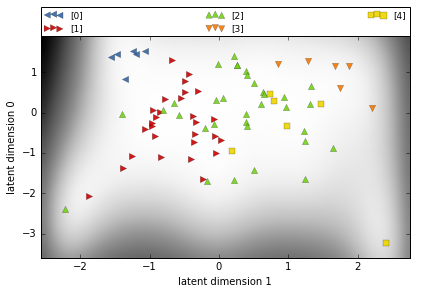

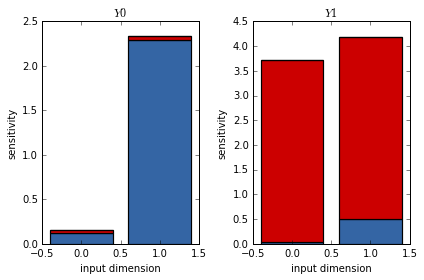

In [25]:
if visualise_output: 
    ax = staticPoseModel.SAMObject.visualise()
    visualiseInfo=dict()
    visualiseInfo['ax']=ax
else:
    visualiseInfo=None

In [26]:
# curTestData = Yall[][None,:].tolist()
def formatDataFunc(Ydata):
        yDataList = []
        for j in range(Ydata.shape[0]):
            yDataList.append(Ydata[j][None,:])
        return yDataList

def testFunc(data, lab):
    d = staticPoseModel.testing(data, False)
    if(lab == d[0]):
        result = True
    else:
        result = False
    print 'Actual  ' + str(lab).ljust(11) + '  Model:  ' + str(d[0]).ljust(11) + '  with ' + str(d[1])[:6] + ' confidence: ' + str(result) + '\n'
    return d

In [27]:
def plot_confusion_matrix(cm, targetNames, title='Confusion matrix', cmap=plt.cm.inferno):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(targetNames))
    plt.xticks(tick_marks, targetNames, rotation=45)
    plt.yticks(tick_marks, targetNames)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=1, truncate=1000):
    while not ar.ready():
        stdouts = ar.stdout
        if any(stdouts):
            clear_output()
            print '-' * 30
            print "%.3fs elapsed" % ar.elapsed
            print ""
            for stdout in ar.stdout:
                if stdout:
                    print "\n%s" % (stdout[-truncate:])
            sys.stdout.flush()
        time.sleep(dt)

In [28]:
c = ipp.Client()
dview = c[:]

with dview.sync_imports():
    from SAM.SAM_Core import staticPose

dview.push({'staticPoseModel':staticPoseModel})

importing staticPose from SAM.SAM_Core on engine(s)


<AsyncResult: _push>

In [29]:
ss = []
sstest = []
print
off1 = 11
off2 = 8

# allCount = Yall.shape[0]
# factor = 40
# numItems = int(allCount/factor)
cmSize = len(staticPoseModel.textLabels)
confMatrix = np.zeros((cmSize, cmSize))
numItems = Yall.shape[0]

off3 = len(str(numItems))

print 'estimated time: ' + str(numItems/60) + 'mins for ' + str(numItems) + ' items'
#format training data

yTrainingData = formatDataFunc(Yall)
YsampleIdx = [ i for i in sorted(random.sample(xrange(len(yTrainingData)),numItems)) ]

Ysample = [yTrainingData[i] for i in YsampleIdx]
Lsample = [staticPoseModel.textLabels[int(Lall[i])] for i in YsampleIdx]

%time syn = dview.map_async(testFunc, Ysample, Lsample)
wait_watching_stdout(syn, dt=1, truncate=1000)
ret = syn.get()
# clear_output()
for i in range(len(ret)):

    currLabel = Lsample[i]

    if(currLabel == ret[i][0]):
        result = True
    else:
        result = False
    print str(i).rjust(off3) + '/' + str(numItems) + ' Truth: ' + currLabel.ljust(off1) + ' Model: ' + ret[i][0].ljust(off1) + ' with ' + str(1-ret[i][1])[:6].ljust(off2) + ' confidence: ' + str(result)
    confMatrix[staticPoseModel.textLabels.index(currLabel),staticPoseModel.textLabels.index(ret[i][0])] += 1
    ss.append(ret[i][0])

------------------------------
5.028s elapsed


 Model:  push_object  with 0.0139 confidence: False

Actual  lift_object  Model:  push_object  with 0.0085 confidence: False

Actual  lift_object  Model:  lift_object  with 0.0085 confidence: True

Actual  lift_object  Model:  push_object  with 0.0083 confidence: False

Actual  lift_object  Model:  pull_object  with 0.0104 confidence: False

Actual  pull_object  Model:  push_object  with 0.0065 confidence: False

Actual  pull_object  Model:  push_object  with 0.0108 confidence: False

Actual  pull_object  Model:  push_object  with 0.0070 confidence: False

Actual  pull_object  Model:  push_object  with 0.0043 confidence: False

Actual  pull_object  Model:  push_object  with 0.0097 confidence: False

Actual  pull_object  Model:  lift_object  with 0.0086 confidence: False

Actual  pull_object  Model:  pull_object  with 0.0122 confidence: True

Actual  pull_object  Model:  push_object  with 0.0076 confidence: False

Actual  pull_object  Mode

[[ 16.66666667   0.           0.           0.          83.33333333]
 [  0.          16.66666667   0.          50.          33.33333333]
 [  0.           0.          33.33333333  16.66666667  50.        ]
 [  7.14285714   0.           3.57142857  10.71428571  78.57142857]
 [ 21.21212121   3.03030303   0.           9.09090909  66.66666667]]


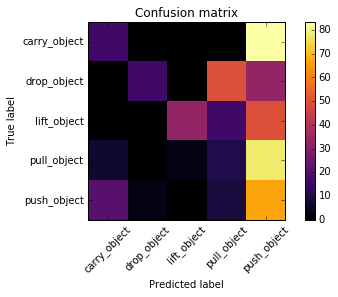

In [30]:
confMatLabels = copy.deepcopy(staticPoseModel.textLabels)
confMatLabels.sort()

from sklearn.metrics import confusion_matrix
h = confusion_matrix(Lsample, ss)
total = h.astype(np.float).sum(axis=1)
normConf = copy.deepcopy(h)
normConf = normConf.astype(np.float)

for l in range(h.shape[0]):
    normConf[l,:] = normConf[l,:].astype(np.float)*100/total[l].astype(np.float)

print normConf

plot_confusion_matrix(normConf, confMatLabels)

In [31]:

percCorect = 100*np.diag(h.astype(np.float)).sum()/numItems

print str(percCorect)[:5].ljust(7) + "% correct for training data"
print
for i in range(cmSize):
    for j in range(cmSize):
        print str(normConf[i,j])[:5].ljust(7) + '% of ' + str(staticPoseModel.textLabels[i]) + ' classified as ' + str(staticPoseModel.textLabels[j])
    print

print

36.70  % correct for training data

16.66  % of lift_object classified as lift_object
0.0    % of lift_object classified as pull_object
0.0    % of lift_object classified as push_object
0.0    % of lift_object classified as drop_object
83.33  % of lift_object classified as carry_object

0.0    % of pull_object classified as lift_object
16.66  % of pull_object classified as pull_object
0.0    % of pull_object classified as push_object
50.0   % of pull_object classified as drop_object
33.33  % of pull_object classified as carry_object

0.0    % of push_object classified as lift_object
0.0    % of push_object classified as pull_object
33.33  % of push_object classified as push_object
16.66  % of push_object classified as drop_object
50.0   % of push_object classified as carry_object

7.142  % of drop_object classified as lift_object
0.0    % of drop_object classified as pull_object
3.571  % of drop_object classified as push_object
10.71  % of drop_object classified as drop_object
78.57  %

In [32]:

# allCount = Yall.shape[0]
# factor = 40
# numItems = int(allCount/factor)
cmSize = len(staticPoseModel.textLabels)
confMatrixTest = np.zeros((cmSize, cmSize))
numItems = YtestAll.shape[0]

off3 = len(str(numItems))

print 'estimated time: ' + str(numItems/60) + 'mins for ' + str(numItems) + ' items'
#format training data

yTrainingData = formatDataFunc(YtestAll)
YsampleIdx = [ i for i in sorted(random.sample(xrange(len(yTrainingData)),numItems)) ]

Ysample = [yTrainingData[i] for i in YsampleIdx]
Lsample = [staticPoseModel.textLabels[int(LtestAll[i])] for i in YsampleIdx]

%time syn = dview.map_async(testFunc, Ysample, Lsample)
wait_watching_stdout(syn, dt=1, truncate=1000)
ret = syn.get()
clear_output()
for i in range(len(ret)):

    currLabel = Lsample[i]

    if(currLabel == ret[i][0]):
        result = True
    else:
        result = False
    print str(i).rjust(off3) + '/' + str(numItems) + ' Truth: ' + currLabel.ljust(off1) + ' Model: ' + ret[i][0].ljust(off1) + ' with ' + str(1-ret[i][1])[:6].ljust(off2) + ' confidence: ' + str(result)
    sstest.append(ret[i][0])

 0/34 Truth: lift_object Model: pull_object with 0.9911   confidence: False
 1/34 Truth: lift_object Model: carry_object with 0.9843   confidence: False
 2/34 Truth: lift_object Model: pull_object with 0.9883   confidence: False
 3/34 Truth: lift_object Model: carry_object with 0.9807   confidence: False
 4/34 Truth: lift_object Model: pull_object with 0.9912   confidence: False
 5/34 Truth: pull_object Model: carry_object with 0.9931   confidence: False
 6/34 Truth: pull_object Model: push_object with 0.9886   confidence: False
 7/34 Truth: pull_object Model: push_object with 0.9915   confidence: False
 8/34 Truth: pull_object Model: push_object with 0.9922   confidence: False
 9/34 Truth: pull_object Model: push_object with 0.9945   confidence: False
10/34 Truth: pull_object Model: push_object with 0.9891   confidence: False
11/34 Truth: pull_object Model: push_object with 0.9963   confidence: False
12/34 Truth: pull_object Model: push_object with 0.9903   confidence: False
13/34 Tru

[[  0.          25.           0.           0.          75.        ]
 [  0.          20.           0.           0.          80.        ]
 [ 40.           0.           0.          60.           0.        ]
 [ 11.11111111  11.11111111   0.           0.          77.77777778]
 [  9.09090909   0.           0.           9.09090909  81.81818182]]


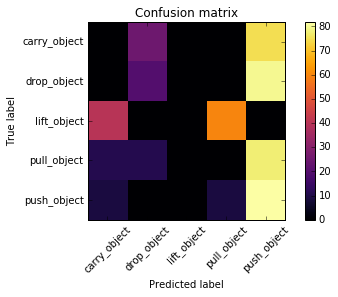

In [33]:
from sklearn.metrics import confusion_matrix
confMatrixTest = confusion_matrix(Lsample, sstest)
total = confMatrixTest.astype(np.float).sum(axis=1)
normConfTest = copy.deepcopy(confMatrixTest)
normConfTest = normConfTest.astype(np.float)

for l in range(confMatrixTest.shape[0]):
    normConfTest[l,:] = normConfTest[l,:].astype(np.float)*100/total[l].astype(np.float)

print normConfTest

plot_confusion_matrix(normConfTest, confMatLabels)

In [34]:
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

percCorect = 100*np.diag(confMatrixTest.astype(np.float)).sum()/numItems 

print str(percCorect)[:5].ljust(7) + "% correct for testing data"
print
for i in range(cmSize):
    for j in range(cmSize):
        print str(normConfTest[i,j])[:5].ljust(7)  + '% of ' + str(staticPoseModel.textLabels[i]) + ' classified as ' + str(staticPoseModel.textLabels[j])
    print

print

29.41  % correct for testing data

0.0    % of lift_object classified as lift_object
25.0   % of lift_object classified as pull_object
0.0    % of lift_object classified as push_object
0.0    % of lift_object classified as drop_object
75.0   % of lift_object classified as carry_object

0.0    % of pull_object classified as lift_object
20.0   % of pull_object classified as pull_object
0.0    % of pull_object classified as push_object
0.0    % of pull_object classified as drop_object
80.0   % of pull_object classified as carry_object

40.0   % of push_object classified as lift_object
0.0    % of push_object classified as pull_object
0.0    % of push_object classified as push_object
60.0   % of push_object classified as drop_object
0.0    % of push_object classified as carry_object

11.11  % of drop_object classified as lift_object
11.11  % of drop_object classified as pull_object
0.0    % of drop_object classified as push_object
0.0    % of drop_object classified as drop_object
77.77  % 